## ES Solar Client Project

This is a Data Science project that I completed for one of my clients. In this project, I utilize Logistic regression to show whether, based on certain aspects of a home/family, a customer is likely to set up an appointment and/or purchase ES Solar's product. I also used the DBSCAN method to see where the tightest clusters of ES Solar's appointments/sales were. You'll notice that all the places where I use the (dataframe).head method are hashtagged, so as to hide sensitive information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 
import seaborn as sns
import os
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import log_loss
print("Libraries Imported")

Libraries Imported


In [2]:
pwd

'/resources/Client Projects/ES Solar'

In [3]:
os.chdir("/resources/Client Projects/ES Solar")

In [4]:
dfpins = pd.read_csv('ESSolarPins.csv')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (22,23,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(dfpins.dtypes)

Lead Owner                          object
Lead Owner Email                    object
CMS ID                              object
Org Unit                            object
Business Name                       object
First Name                          object
Last Name                           object
Address 1                           object
Address 2                           object
City                                object
State                               object
Zip                                float64
Latitude                           float64
Longitude                          float64
Primary Phone                       object
Alternate Phone                     object
Email                               object
Status                              object
Appointment                         object
Date Created                        object
Date Modified                       object
Date Status Modified                object
Disqualified                        object
Agents Name

Some things need to be removed immediately from the dataframe. In the "Status" column, for example, we have a few pins that, while cumbersome, also present no valuable information whatsoever, such as the "No Answers." These are dropped from the dataframe. The columns 'Business Name','Lead Owner Email','CMS ID','Address 2','Agents Name','Agents Phone','Agents Email','Sunlight Result','Disqualified','Sale Date','Credit Score','Annual Household Income > 50K?','Moving In The Next 12 Months?' are removed because they provide no value to the dataframe. Some columns are renamed to be more easily queriable, and some NaN values are dropped.

In [6]:
dfpins.drop(columns=['Business Name','Lead Owner Email','CMS ID','Address 2','Agents Name','Agents Phone','Agents Email','Sunlight Result','Disqualified','Sale Date','Credit Score','Annual Household Income > $50K?','Moving In The Next 12 Months?'],inplace=True)
dfpins.dropna(subset=['Latitude'],inplace=True)
dfpins.dropna(subset=['Longitude'],inplace=True)
dfpins.rename(columns={'First Name': 'Firstname', 'Last Name': 'Lastname', 'Lead Owner':'Owner','Org Unit':'Org','Address 1':'Address','Primary Phone':'Phone','Alternate Phone':'Phone2','Date Created':'DateCreated','Date Modified':'DateModified','Date Status Modified':'DateStatusModified'}, inplace=True)
dfpins.drop(columns=['DateCreated','DateModified','DateStatusModified','Org'],inplace=True)


In [7]:
print(dfpins.dtypes)

Owner           object
Firstname       object
Lastname        object
Address         object
City            object
State           object
Zip            float64
Latitude       float64
Longitude      float64
Phone           object
Phone2          object
Email           object
Status          object
Appointment     object
dtype: object


We have our cleaned dataset, and are ready to pair it with the "Datagrid" csv, which we've pulled from SalesRabbit's Metabase

In [8]:
#Clean the Datagrid Dataframe and join it on df
dfgrid=pd.read_csv('Datagrid.csv')
#dfgrid.head()

In [9]:
dfgrid.dropna(subset=['Squarefootage'],inplace=True)
dfgrid.dropna(subset=['Yearhomebuilt'],inplace=True)
#dfgrid.head()

In [10]:
dfraw = pd.merge(dfpins, dfgrid, on='Address')

In [11]:
dfraw.describe()

,Zip,Latitude_x,Longitude_x,Universaldatagridid,Age,Buildingvalue,Cabletv,Charitabledonations,Childrenathome,Creditrating,...,Income,Latitude_y,Longitude_y,Networth,Primarylanguage,Squarefootage,Standardizedaddressid,Yearhomebuilt,Zip4,Zipcode
count,14910.000000,14915.000000,14915.000000,1.491500e+04,14915.000000,1.491500e+04,14915.0,14915.000000,14915.000000,14915.000000,...,14915.000000,14915.000000,14915.000000,1.491500e+04,0.0,14915.000000,1.490000e+04,14915.000000,14915.000000,14915.000000
mean,84284.822535,41.180923,-112.011275,6.001899e+07,45.350386,3.174280e+05,0.0,0.545558,0.583976,531.210191,...,112978.712705,41.180621,-112.012745,2.932241e+05,NaN,827.592156,1.402443e+08,1942.438485,5780.850888,84233.663091
std,6198.256244,0.082424,0.214431,3.448925e+07,21.291962,1.230076e+05,0.0,0.497937,0.492914,314.047072,...,64877.009672,0.081971,0.055603,2.798302e+05,NaN,941.963301,4.023845e+07,310.016602,2831.679347,180.981568
min,84014.000000,40.838463,-112.159283,9.700800e+04,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,...,0.000000,40.997959,-112.159393,0.000000e+00,NaN,0.000000,1.136960e+08,0.000000,105.000000,84015.000000
25%,84041.000000,41.113578,-112.057412,3.010477e+07,36.000000,2.390000e+05,0.0,0.000000,0.000000,0.000000,...,67500.000000,41.113365,-112.057125,6.250000e+04,NaN,0.000000,1.219834e+08,1978.000000,3216.000000,84041.000000
50%,84401.000000,41.171294,-112.012107,6.083683e+07,46.000000,2.940000e+05,0.0,1.000000,1.000000,675.000000,...,97500.000000,41.171139,-112.011368,2.000000e+05,NaN,0.000000,1.276066e+08,1997.000000,6110.000000,84401.000000
75%,84404.000000,41.247818,-111.962777,8.991282e+07,60.000000,3.800000e+05,0.0,1.000000,1.000000,725.000000,...,142500.000000,41.247570,-111.962563,3.750000e+05,NaN,1528.000000,1.391501e+08,2005.000000,8518.500000,84404.000000
max,840759.000000,41.684390,-86.727924,1.189968e+08,99.000000,2.079000e+06,0.0,1.000000,1.000000,825.000000,...,300000.000000,41.349869,-111.897392,1.250000e+06,NaN,7965.000000,4.472448e+08,2019.000000,9869.000000,84414.000000


In [12]:
print(dfraw.dtypes)

Owner                     object
Firstname_x               object
Lastname_x                object
Address                   object
City_x                    object
State_x                   object
Zip                      float64
Latitude_x               float64
Longitude_x              float64
Phone                     object
Phone2                    object
Email                     object
Status                    object
Appointment               object
Universaldatagridid        int64
Firstname_y               object
Lastname_y                object
Addressall                object
Age                        int64
Buildingvalue              int64
Cabletv                    int64
Charitabledonations        int64
Childrenathome             int64
City_y                    object
Creditcarduser              bool
Creditrating               int64
Donotcall                   bool
Frequentremodeler           bool
Gender                    object
Greenliving                 bool
Hassatelli

In [13]:
dfraw = dfraw.drop(columns=['Universaldatagridid','Firstname_y','Lastname_y','Addressall','City_y','Latitude_y','Longitude_y','Personalid','Standardizedaddressid','State_y','Appointment','Homeownerrenter','Homepropertytype','Leadstatuscode','Primarylanguage','Zip4','Zipcode','Donotcall'])
dfraw.rename(columns={'Firstname_x':'Firstname','Lastname_x':'Lastname','City_x':'City','Latitude_x':'Latitude','Longitude_x':'Longitude','State_x':'State'}, inplace=True)


In [14]:
#dfraw.head()

Now that we have removed columns that we obviously don't need, and renamed some columns that were changed due to the data merge, we need to do some exploration into the other variables.

The first variable we'll start with is Status, and we'll create a dummy variable showing whether an appointment was set at a home or not

In [15]:
dfraw['Status'].describe()

count            14915
unique              19
top       No Solicting
freq              3646
Name: Status, dtype: object

In [16]:
dfraw['Status'].value_counts()

No Solicting           3646
No Answer 1            2674
Not Interested         1379
Has Solar Other        1334
Follow Up              1274
SS Appointment Set     1146
Disqualified           1039
Renters                 562
No Answer 2             405
For Sale                371
Setter Gold             368
SOLD                    182
ES Customer             173
Do Not Knock            112
New Mover                97
No Show                  84
No Answer 3              45
ET Gold                  15
Insulation Customer       9
Name: Status, dtype: int64

In [17]:
filt = dfraw['Status']=='No Solicting'
filt2 = dfraw['Status']=='No Answer 1'
filt3 = dfraw['Status']=='Has Solar Other'
filt4 = dfraw['Status']=='Renters'
filt5 = dfraw['Status']=='For Sale'
filt6 = dfraw['Status']=='No Answer 2'
filt9 = dfraw['Status']=='No Answer 3'
#filt7 = dfraw['Status']=='ES Customer'
filt8 = dfraw['Status']=='Disqualified'

dfraw.drop(index=dfraw[filt].index, inplace=True)
#dfraw.drop(index=dfraw[filt7].index, inplace=True)
dfraw.drop(index=dfraw[filt2].index, inplace=True)
dfraw.drop(index=dfraw[filt3].index, inplace=True)
dfraw.drop(index=dfraw[filt4].index, inplace=True)
dfraw.drop(index=dfraw[filt5].index, inplace=True)
dfraw.drop(index=dfraw[filt6].index, inplace=True)
dfraw.drop(index=dfraw[filt8].index, inplace=True)
dfraw.drop(index=dfraw[filt9].index, inplace=True)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:

In [18]:
dfraw['Status'].describe()

count               4839
unique                11
top       Not Interested
freq                1379
Name: Status, dtype: object

In [19]:
dfraw['Status'].value_counts()

Not Interested         1379
Follow Up              1274
SS Appointment Set     1146
Setter Gold             368
SOLD                    182
ES Customer             173
Do Not Knock            112
New Mover                97
No Show                  84
ET Gold                  15
Insulation Customer       9
Name: Status, dtype: int64

In [20]:
ApptSetdummy=[]
for status in dfraw['Status']:
    if status == 'SS Appointment Set':
        ApptSetdummy.append(1)
    elif status== 'SOLD':
        ApptSetdummy.append(1)
    elif status=='ES Customer':
        ApptSetdummy.append(1)
    else:
        ApptSetdummy.append(0)
dfraw['ApptSetdummy']=ApptSetdummy

In [21]:
dfraw['ApptSetdummy'].value_counts()

0    3338
1    1501
Name: ApptSetdummy, dtype: int64

In [22]:
Solddummy=[]
for status in dfraw['Status']:
    if status== 'SOLD':
        Solddummy.append(1)
    elif status=='ES Customer':
        Solddummy.append(1)
    else:
        Solddummy.append(0)
dfraw['Solddummy']=Solddummy

In [23]:
dfraw['Solddummy'].value_counts()

0    4484
1     355
Name: Solddummy, dtype: int64

### Now that we have our dummy variable columns, we'll continue down the list of these columns. Since we don't know much about any of them, we need to do some exploration

In [24]:
describe=[]
valuecounts=[]
for col in dfraw.columns:
    describe.append(dfraw[col].describe())
    valuecounts.append(dfraw[col].value_counts())

In [25]:
dfdescriptions = {'Index':dfraw.columns,'Description':describe,'Valuecounts':valuecounts}

In [26]:
dfdescriptions = pd.DataFrame(dfdescriptions)

In [27]:
dfdescriptions

,Index,Description,Valuecounts
0,Owner,count 4839 unique 53 ...,Kaden Coziar 343 Stefani Abuzov ...
1,Firstname,count 2421 unique 1856 top Scot...,Scott 17 Chris 1...
2,Lastname,count 1482 unique 1211 top Smit...,Smith 15 Johnson 10 Brown 7 H...
3,Address,count 4839 unique ...,2600 N Fairfield Rd 28 3921 W 2400 N ...
4,City,count 4837 unique 38 top Ogde...,Ogden 857 Layton ...
5,State,count 4832 unique 1 top UT f...,"UT 4832 Name: State, dtype: int64"
6,Zip,count 4835.000000 mean 84392.976836 ...,84015.0 767 84404.0 689 84414.0 64...
7,Latitude,count 4839.000000 mean 41.180168 std ...,41.287205 3 41.094227 2 41.112273 2 4...
8,Longitude,count 4839.000000 mean -112.004305 std ...,-111.983395 3 -111.926021 2 -112.056533 ...
9,Phone,count 2029 unique 1...,(801) 555-2222 12 (801) 920-3671 3 (801...


In [28]:
for index, row in dfdescriptions.iterrows():
    print(row['Index'], row['Description'], row['Valuecounts'])

Owner count             4839
unique              53
top       Kaden Coziar
freq               343
Name: Owner, dtype: object Kaden Coziar          343
Stefani Abuzov        340
Larie Hannum          295
Ben Mitchell          291
Braxton Ovard         270
Heidi Sholly          255
Rhett Kelton          249
Kaysen Morzelewski    224
Jeff Roundy           215
Anthony Torres        206
Caleb Sholly          180
Stefan Di Febo        179
Max  Jones            169
Brayden Macfarlane    131
Dallin Smith          129
Brock Samuels         128
Brayden Longman       112
Jerry Springer        103
Aaron Holloway         98
Cody Dehut             83
Trae Sholly            82
Alannah Buttram        76
Braxton Loock          66
Devon Blosser          63
Jaylon Ford            53
Devry Caperton         46
Ethan Davis            44
Kenneth Nelson         43
Nick Perry             42
Eli Greer              42
Alex Thomas            38
Mason Jones            34
Gavin Campbell         27
Beau Ellsworth   

#### Drop Columns

In [29]:
dfraw = dfraw.drop(columns=['Cabletv','Occupation','Creditrating','Hassatellite','Householdsize','Infant','Lengthofresidence','Numcreditlines','Position','Premiumcard','Phone','Phone2','Email'])


#### Make NaN from some categories as the average of those categories

In [30]:
#Age, Building Value, Home Value, Income, Net worth, Year Home built

#Rows affected may or may not reference the same row as those mentioned by other changes
dfraw.Age.replace({0:44.759499},inplace=True)
#579 rows affected
dfraw.Buildingvalue.replace({0:324580.7},inplace=True)
#83 rows affected
dfraw.Homevalue.replace({0:392043},inplace=True)
#85 rows affected
dfraw.Income.replace({0:115275.949904},inplace=True)
#2 rows affected
dfraw.Networth.replace({0:311398.3},inplace=True)
#6 rows affected
dfraw.Yearhomebuilt.replace({0:1933},inplace=True)
#138 rows affected

#### Note to drop NaN from these variables in their own dataframes

- Squarefootage: has over 1600 NaN's, which is roughly a third of the data. Including Square footage, however, greatly increases the variance score, so we must include it.

In [31]:
filtsqf = dfraw['Squarefootage']==0
dfraw.drop(index=dfraw[filt].index, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [32]:
dfraw.describe()

,Zip,Latitude,Longitude,Age,Buildingvalue,Charitabledonations,Childrenathome,Homesaledate,Homevalue,Income,Networth,Squarefootage,Yearhomebuilt,ApptSetdummy,Solddummy
count,4835.000000,4839.000000,4839.000000,4839.000000,4.839000e+03,4839.000000,4839.000000,4102.000000,4.839000e+03,4839.000000,4.839000e+03,4839.000000,4839.000000,4839.000000,4839.000000
mean,84392.976836,41.180168,-112.004305,50.114730,3.302246e+05,0.541021,0.603017,2011.856168,3.990333e+05,114860.622422,3.089398e+05,819.481298,1989.921058,0.310188,0.073362
std,10881.358869,0.085125,0.367854,14.203753,1.200334e+05,0.498366,0.489323,6.910815,1.367629e+05,64217.905333,2.894848e+05,966.756041,22.344275,0.462618,0.260757
min,84015.000000,40.838463,-112.155002,20.000000,7.580000e+02,0.000000,0.000000,1981.000000,2.352200e+04,7500.000000,7.500000e+03,0.000000,1900.000000,0.000000,0.000000
25%,84041.000000,41.107397,-112.056210,40.000000,2.480000e+05,0.000000,0.000000,2007.000000,3.053780e+05,72500.000000,8.750000e+04,0.000000,1978.000000,0.000000,0.000000
50%,84401.000000,41.168424,-112.007796,45.000000,3.110000e+05,1.000000,1.000000,2015.000000,3.771980e+05,97500.000000,2.000000e+05,0.000000,1997.000000,0.000000,0.000000
75%,84404.000000,41.250793,-111.955009,59.000000,3.880000e+05,1.000000,1.000000,2017.000000,4.649780e+05,142500.000000,3.750000e+05,1561.000000,2005.000000,1.000000,0.000000
max,840759.000000,41.684390,-86.727924,99.000000,2.079000e+06,1.000000,1.000000,2019.000000,2.392718e+06,300000.000000,1.250000e+06,6318.000000,2019.000000,1.000000,1.000000


In [33]:
#Changing the booleans to binary

Creditcarduserdummy=[]
for item in dfraw['Creditcarduser']:
    if item== True:
        Creditcarduserdummy.append(1)
    else:
        Creditcarduserdummy.append(0)
dfraw['Creditcarduserdummy']=Creditcarduserdummy

Frequentremodelerdummy=[]
for item in dfraw['Frequentremodeler']:
    if item== True:
        Frequentremodelerdummy.append(1)
    else:
        Frequentremodelerdummy.append(0)
dfraw['Frequentremodelerdummy']=Frequentremodelerdummy

Genderdummy=[]
for item in dfraw['Gender']:
    if item=='m':
        Genderdummy.append(1)
    else:
        Genderdummy.append(0)
dfraw['Genderdummy']=Genderdummy

Genderdummy=[]
for item in dfraw['Gender']:
    if item=='m':
        Genderdummy.append(1)
    else:
        Genderdummy.append(0)
dfraw['Genderdummy']=Genderdummy

Maritalstatusdummy=[]
for item in dfraw['Maritalstatus']:
    if item==True:
        Maritalstatusdummy.append(1)
    else:
        Maritalstatusdummy.append(0)
dfraw['Maritalstatusdummy']=Maritalstatusdummy

Multigenerationaldummy=[]
for item in dfraw['Multigenerational']:
    if item==True:
        Multigenerationaldummy.append(1)
    else:
        Multigenerationaldummy.append(0)
dfraw['Multigenerationaldummy']=Multigenerationaldummy

Politicaldonordummy=[]
for item in dfraw['Politicaldonor']:
    if item==True:
        Politicaldonordummy.append(1)
    else:
        Politicaldonordummy.append(0)
dfraw['Politicaldonordummy']=Politicaldonordummy

In [34]:
print(dfraw.dtypes)

Owner                      object
Firstname                  object
Lastname                   object
Address                    object
City                       object
State                      object
Zip                       float64
Latitude                  float64
Longitude                 float64
Status                     object
Age                       float64
Buildingvalue             float64
Charitabledonations         int64
Childrenathome              int64
Creditcarduser               bool
Frequentremodeler            bool
Gender                     object
Greenliving                  bool
Homesaledate              float64
Homevalue                   int64
Income                    float64
Maritalstatus                bool
Multigenerational            bool
Networth                  float64
Politicaldonor               bool
Squarefootage               int64
Yearhomebuilt               int64
ApptSetdummy                int64
Solddummy                   int64
Creditcarduser

# Setting Variables for All Regressions

In [35]:
dfraw.rename(columns={'Creditcarduserdummy':'Creditcarduser*','Frequentremodelerdummy':'Frequentremodeler*','Genderdummy':'Gender*','Maritalstatusdummy':'Maritalstatus*','Multigenerationaldummy':'Multigenerational*','Politicaldonordummy':'Politicaldonor*'},inplace=True)

In [36]:
Varlist = ['Age','Charitabledonations','Childrenathome','Homevalue','Income','Networth','Squarefootage','Yearhomebuilt','Creditcarduser*','Frequentremodeler*','Gender*','Maritalstatus*','Multigenerational*','Politicaldonor*']

# Creating the Model for Appointments

### Logistic Regression

In [37]:
X = np.asarray(dfraw[Varlist])
X[0:5]

array([[4.1000000e+01, 0.0000000e+00, 1.0000000e+00, 2.3697800e+05,
        3.2500000e+04, 8.7500000e+04, 0.0000000e+00, 1.9540000e+03,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [4.1000000e+01, 0.0000000e+00, 1.0000000e+00, 2.3697800e+05,
        3.2500000e+04, 8.7500000e+04, 0.0000000e+00, 1.9540000e+03,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [4.5000000e+01, 1.0000000e+00, 1.0000000e+00, 4.7181800e+05,
        1.7500000e+05, 2.0000000e+05, 0.0000000e+00, 2.0040000e+03,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [6.4000000e+01, 1.0000000e+00, 0.0000000e+00, 2.9967800e+05,
        2.3750000e+05, 3.7500000e+05, 0.0000000e+00, 1.9760000e+03,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.4759499e+01, 0.000

In [38]:
y = np.asarray(dfraw['ApptSetdummy'])
y [0:5]

array([1, 1, 1, 1, 0])

In [39]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.64177912, -1.08570176,  0.81137391, -1.18505842, -1.28265058,
        -0.76502332, -0.8477485 , -1.60778414, -1.5235511 , -0.89680018,
         0.59270441, -1.9301777 ,  1.2208516 ,  0.35699638],
       [-0.64177912, -1.08570176,  0.81137391, -1.18505842, -1.28265058,
        -0.76502332, -0.8477485 , -1.60778414, -1.5235511 , -0.89680018,
         0.59270441, -1.9301777 ,  1.2208516 ,  0.35699638],
       [-0.36013432,  0.92106326,  0.81137391,  0.53225093,  0.93658602,
        -0.37636175, -0.8477485 ,  0.63015681,  0.65636131,  1.1150756 ,
         0.59270441,  0.51808701,  1.2208516 ,  0.35699638],
       [ 0.97767852,  0.92106326, -1.23247739, -0.72655349,  1.90993541,
         0.22822291, -0.8477485 , -0.62309012,  0.65636131,  1.1150756 ,
        -1.68718164,  0.51808701, -0.81910037,  0.35699638],
       [-0.37706828, -1.08570176,  0.81137391,  0.02372729,  0.27470844,
        -0.37636175, -0.8477485 ,  0.98822737, -1.5235511 , -0.89680018,
         0.59270441,  0.51

In [40]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3871, 14) (3871,)
Test set: (968, 14) (968,)


In [41]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.71303002, 0.28696998],
       [0.51381526, 0.48618474],
       [0.65474955, 0.34525045],
       ...,
       [0.63668647, 0.36331353],
       [0.53843165, 0.46156835],
       [0.70116838, 0.29883162]])

In [44]:
jaccard_similarity_score(y_test, yhat)

0.7004132231404959

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[  2 285]
 [  5 676]]


Confusion matrix, without normalization
[[  2 285]
 [  5 676]]


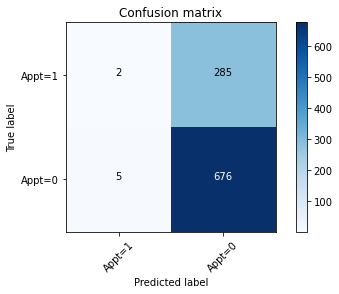

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Appt=1','Appt=0'],normalize= False,  title='Confusion matrix')

In [47]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82       681
           1       0.29      0.01      0.01       287

   micro avg       0.70      0.70      0.70       968
   macro avg       0.49      0.50      0.42       968
weighted avg       0.58      0.70      0.58       968



In [48]:
log_loss(y_test, yhat_prob)

0.6021509603144081

In [49]:
print ('Coefficients: ', LR.coef_)
Apptcoef=LR.coef_


Coefficients:  [[-0.14 -0.12  0.03 -0.02 -0.02 -0.05 -0.31 -0.06  0.04  0.09 -0.04  0.01
   0.04  0.03]]


In [50]:
Apptcoefdict = dict(zip(Varlist,Apptcoef[0]))

In [51]:
print(Apptcoefdict)

{'Age': -0.13674432362784947, 'Charitabledonations': -0.12008377163660133, 'Childrenathome': 0.032881790624594176, 'Homevalue': -0.024131118366856007, 'Income': -0.018621490250399754, 'Networth': -0.05357816851239254, 'Squarefootage': -0.3140298824185902, 'Yearhomebuilt': -0.061956043109039266, 'Creditcarduser*': 0.03730105536414693, 'Frequentremodeler*': 0.08881233090314054, 'Gender*': -0.04367276392101111, 'Maritalstatus*': 0.007235029372837179, 'Multigenerational*': 0.044290626780511856, 'Politicaldonor*': 0.03257539175349157}


In [52]:
Adf = pd.DataFrame(Apptcoefdict.items(), columns=['Variable', 'Coefficient'])
Adf

,Variable,Coefficient
0,Age,-0.136744
1,Charitabledonations,-0.120084
2,Childrenathome,0.032882
3,Homevalue,-0.024131
4,Income,-0.018621
5,Networth,-0.053578
6,Squarefootage,-0.314030
7,Yearhomebuilt,-0.061956
8,Creditcarduser*,0.037301
9,Frequentremodeler*,0.088812


# Creating the Model for Sales

### Logistic Regression

In [53]:
X = np.asarray(dfraw[Varlist])
X[0:5]

array([[4.10e+01, 0.00e+00, 1.00e+00, 2.37e+05, 3.25e+04, 8.75e+04,
        0.00e+00, 1.95e+03, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00],
       [4.10e+01, 0.00e+00, 1.00e+00, 2.37e+05, 3.25e+04, 8.75e+04,
        0.00e+00, 1.95e+03, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00],
       [4.50e+01, 1.00e+00, 1.00e+00, 4.72e+05, 1.75e+05, 2.00e+05,
        0.00e+00, 2.00e+03, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00],
       [6.40e+01, 1.00e+00, 0.00e+00, 3.00e+05, 2.38e+05, 3.75e+05,
        0.00e+00, 1.98e+03, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00],
       [4.48e+01, 0.00e+00, 1.00e+00, 4.02e+05, 1.32e+05, 2.00e+05,
        0.00e+00, 2.01e+03, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00]])

In [54]:
y = np.asarray(dfraw['Solddummy'])
y [0:5]

array([0, 0, 0, 0, 0])

In [55]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.64, -1.09,  0.81, -1.19, -1.28, -0.77, -0.85, -1.61, -1.52,
        -0.9 ,  0.59, -1.93,  1.22,  0.36],
       [-0.64, -1.09,  0.81, -1.19, -1.28, -0.77, -0.85, -1.61, -1.52,
        -0.9 ,  0.59, -1.93,  1.22,  0.36],
       [-0.36,  0.92,  0.81,  0.53,  0.94, -0.38, -0.85,  0.63,  0.66,
         1.12,  0.59,  0.52,  1.22,  0.36],
       [ 0.98,  0.92, -1.23, -0.73,  1.91,  0.23, -0.85, -0.62,  0.66,
         1.12, -1.69,  0.52, -0.82,  0.36],
       [-0.38, -1.09,  0.81,  0.02,  0.27, -0.38, -0.85,  0.99, -1.52,
        -0.9 ,  0.59,  0.52, -0.82,  0.36]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3871, 14) (3871,)
Test set: (968, 14) (968,)


In [57]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [59]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.88, 0.12],
       [0.88, 0.12],
       [0.89, 0.11],
       ...,
       [0.87, 0.13],
       [0.85, 0.15],
       [0.88, 0.12]])

In [60]:
jaccard_similarity_score(y_test, yhat)

0.9276859504132231

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[  0  70]
 [  0 898]]


Confusion matrix, without normalization
[[  0  70]
 [  0 898]]


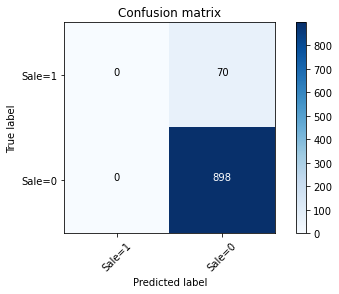

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Sale=1','Sale=0'],normalize= False,  title='Confusion matrix')

In [63]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       898
           1       0.00      0.00      0.00        70

   micro avg       0.93      0.93      0.93       968
   macro avg       0.46      0.50      0.48       968
weighted avg       0.86      0.93      0.89       968



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
log_loss(y_test, yhat_prob)

0.2742344073327229

In [65]:
print ('Coefficients: ', LR.coef_)
Salecoef=LR.coef_

Coefficients:  [[-0.08 -0.    0.02  0.05 -0.08 -0.02 -0.11  0.01 -0.01  0.02 -0.01  0.04
  -0.01 -0.01]]


In [66]:
Salecoefdict = dict(zip(Varlist,Salecoef[0]))

In [67]:
print(Salecoefdict)

{'Age': -0.07606877695803856, 'Charitabledonations': -0.0018248525513981058, 'Childrenathome': 0.015749221902787363, 'Homevalue': 0.050959043690745456, 'Income': -0.07707214515902722, 'Networth': -0.018934900715580537, 'Squarefootage': -0.10862309838445668, 'Yearhomebuilt': 0.009369284070184183, 'Creditcarduser*': -0.006552651077507321, 'Frequentremodeler*': 0.01589429628289433, 'Gender*': -0.005048290878934957, 'Maritalstatus*': 0.036659602868410635, 'Multigenerational*': -0.011674475048050885, 'Politicaldonor*': -0.010335963314362321}


In [68]:
Sdf = pd.DataFrame(Salecoefdict.items(), columns=['Variable', 'Coefficient'])
Sdf

,Variable,Coefficient
0,Age,-0.076069
1,Charitabledonations,-0.001825
2,Childrenathome,0.015749
3,Homevalue,0.050959
4,Income,-0.077072
5,Networth,-0.018935
6,Squarefootage,-0.108623
7,Yearhomebuilt,0.009369
8,Creditcarduser*,-0.006553
9,Frequentremodeler*,0.015894


# DBSCAN

In [69]:
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge  basemap==1.1.0  matplotlib==2.2.2  -y
import folium # plotting library
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from geopy import geocoders
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut
from IPython.display import Image 
from IPython.core.display import HTML 
print('Libraries Imported')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - basemap==1.1.0

Current channels:

  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarc

In [70]:
dfappts = dfpins[dfpins['Status']=='SS Appointment Set']
dfsold = dfpins[dfpins['Status']=='SOLD']
dfcust = dfpins[dfpins['Status']=='ES Customer']
dfappts.append(dfsold)
dfappts.append(dfcust)

dfsales = dfsold.append(dfcust)


In [71]:
address = '979 N 400 W, Layton UT'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

41.0697928 -111.9722334


## Scanning Sales

In [72]:
x=dfsales['Latitude']
y=dfsales['Longitude']
X = np.array(list(zip(x,y))).reshape(len(x), 2)

In [73]:
epsilonsales = 0.01
#0.689722 mile radius
minimumSamples = 10
db = DBSCAN(eps=epsilonsales, min_samples=minimumSamples).fit(X)
labels = db.labels_
#labels

In [74]:
# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
#core_samples_mask

In [75]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

12

In [76]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
#unique_labels

In [77]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

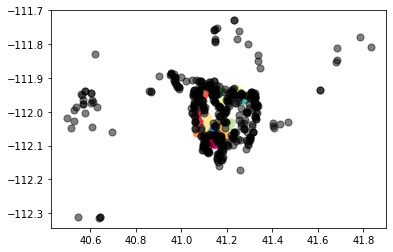

In [78]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [79]:
dfsales['class_member_mask']=class_member_mask
dfsales['core_samples_mask']=core_samples_mask
df_core_sales=dfsales[dfsales.core_samples_mask!=False]
df_notcore_sales=dfsales[dfsales.core_samples_mask==False]

In [80]:
# create map of Ogden using latitude and longitude values
map_layton_sales = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng in zip(df_core_sales['Latitude'], df_core_sales['Longitude']):
    label = 'Appt'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_layton_sales)  

#for lat, lng in zip(df_notcore_sales['Latitude'], df_notcore_sales['Longitude']):
    #label = 'Appt'
    #label = folium.Popup(label, parse_html=True)
    #folium.CircleMarker(
        #[lat, lng],
        #radius=5,
        #popup=label,
        #color='yellow',
        #fill=True,
        #fill_color='#FFFF00',
        #fill_opacity=0.7,
        #parse_html=False).add_to(map_layton_sales)    
    
map_layton_sales

## Scanning Appts

In [81]:
x=dfappts['Latitude']
y=dfappts['Longitude']
X = np.array(list(zip(x,y))).reshape(len(x), 2)

In [82]:
epsilonappts = 0.0076
#0.5242 mile radius
minimumSamples = 25
db = DBSCAN(eps=epsilonappts, min_samples=minimumSamples).fit(X)
labels = db.labels_
#labels

In [83]:
# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
#core_samples_mask

In [84]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

13

In [85]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
#unique_labels

In [86]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

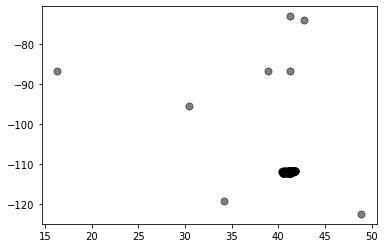

In [87]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [88]:
dfappts['class_member_mask']=class_member_mask
dfappts['core_samples_mask']=core_samples_mask
df_core_appts=dfappts[dfappts.core_samples_mask!=False]
df_notcore_appts=dfappts[dfappts.core_samples_mask==False]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [89]:
#Core Appointments
for lat, lng in zip(df_core_appts['Latitude'], df_core_appts['Longitude']):
    label = 'Appt'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#0000FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_layton_sales)

#Not Core Appointments
#for lat, lng in zip(df_notcore_appts['Latitude'], df_notcore_appts['Longitude']):
    #label = 'Appt'
    #label = folium.Popup(label, parse_html=True)
    #folium.CircleMarker(
        #[lat, lng],
        #radius=5,
        #popup=label,
        #color='white',
        #fill=True,
        #fill_color='#FFFFFF',
        #fill_opacity=0.7,
        #parse_html=False).add_to(map_layton_sales)   
    
map_layton_sales